# Proto Assignment 5 - General Adversariel Network (GAN) Monet Painting Style Transfer

## Description

This project is a GAN based style transformation. The goal of this project is to develop a GAN model that can accurately transfer the Monet style of paintings to a photograph. The model will train on sample Monet painting images learning the Monet style.  It will then reproduce photographs in the Monet style. The data is provided by  the Kaggle competition 'I'm Somewhat of a Painter Myself' Competition and located at https://www.kaggle.com/competitions/gan-getting-started.


CycleGAN a very popular extension of the GAN architecture will be used to develope the model.  CycleGan deploys two Generator and discriminator models to create the style transfer paramters.  

Describe CycleGan

describe  generative deep learning models

Generative AI is a type of AI that uses deep learning techniques to generate new content, such as images, music, and text.

Given that the course material was a very brief, high level review of GAN theory and did not cover implementation of GAN models, this project will rely heavily on the tutorials in the references for implementation guidance.  Custom adaptations will be injected where possible to build a unique project structured around the tutorials base structures.  The course did not offer specifics into the CycleGAN package

## Data Summary


In [3]:

#File Maintainance
#!pip
#!rm *.jpg
#!mkdir images
import os
# print(os.getcwd())
# print(os.listdir())
# print(os.chdir('/kaggle'))
# print(os.listdir())
# #!mkdir tmp
# print(os.chdir('/kaggle/working'))
# print(os.listdir())
# !rm images.zip
# print(os.listdir())
# print(os.getcwd())
# print(os.chdir('/kaggle/images'))
# print(os.getcwd())
# #!rm *.jpg
# print(os.listdir())

# #Set Page Width to 100%
# from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

#Load Required Resources
import os
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa

import matplotlib.pyplot as plt

import tensorflow as tf

#from Monet CycleGAN Tutorial
#Uncomment for use in KAggle notebook
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.12.0


**Build Dataset**

As loading the data set is beyond the scope of this project the 'Load in the Data' code provided in the Kaggel tutorial will be implemented.  

In [3]:
#Kaggle Notebook Data Import
#from Monet CycleGAN Tutorial
#Uncomment for use in KAggle notebook
GCS_PATH = KaggleDatasets().get_gcs_path()

monet_filename_id = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Count of Monet TF record Files:', len(monet_filename_id))

photo_filename_id = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Count of Photo TF record Files: ', len(photo_filename_id))

Count of Monet TF record Files: 5
Count of Photo TF record Files:  20


In [ ]:
# Local Data Import
# The .tfrec files from the Kaggle Competition site will be used
#Comment out for use in KAggle Notebook
# monet_filename_id = tf.io.gfile.glob(str('monet_tfrec/*.tfrec'))
# print('Count of Monet TF record Files: ', len(monet_filename_id))

# photo_filename_id = tf.io.gfile.glob(str('photo_tfrec/*.tfrec'))
# print('Count of Photo TF record Files: ', len(photo_filename_id))

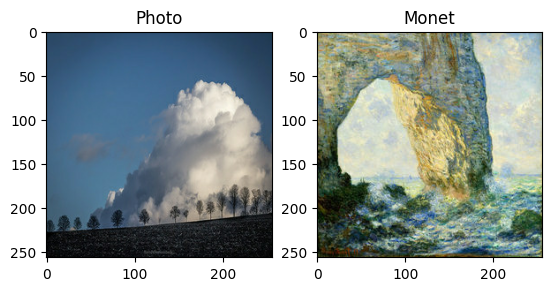

In [8]:
# Scale the images and pull only the image files
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

#Example and visualize scaled images

monet_ds = load_dataset(monet_filename_id, labeled=True).batch(1)
photo_ds = load_dataset(photo_filename_id, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### EDA

EDA will be performed as follows:

    1. Verify Train Image Counts and Size
    2. Verify Test Image Counts and size
    3. Provide Sample Monet and photograh images

Various random images, and thier sizes were reviewed and the Monet images are assessed to be of the Monet style and photo images are photgraphs.  Given that the images and photos are directly from the competition dataset, and the dompetition dataset is assumed to be in the porper condition no addtional EDA is requied.

In [9]:
# Sample Images and sizes
monet_file_id_df = pd.DataFrame(monet_filename_id)
print('Monet File Summary:')
print(monet_file_id_df.head())
print(monet_file_id_df.info())

photo_file_id_df = pd.DataFrame(photo_filename_id)
print('Photo FileSummary:')
print(photo_file_id_df.head())
print(photo_file_id_df.info())

Monet File Summary:
                                                   0
0  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
1  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
2  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
3  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
4  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes
None
Photo FileSummary:
                                                   0
0  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
1  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
2  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
3  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
4  gs://kds-c9c6b95b166162573ee9220e81a91aeba3c26...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 

In [ ]:
# Plot Example Images


# monet1 = plt.imread(GCS_PATH + 'monet_jpg/0a5075d42a.jpg')
# print('Monet Sample Image 1 Shape')
# print(monet1.shape)
# plt.imshow(monet1)
# plt.title('Monet Sample Image 1')
# plt.show()

# monet2 = plt.imread('monet_jpg/0bd913dbc7.jpg')
# print('Monet Sample Image 2 Shape')
# print(monet2.shape)
# plt.imshow(monet2)
# plt.title('Monet Sample Image 2')
# plt.show()

# photo1 = plt.imread('photo_jpg/0a0c3a6d07.jpg')
# print('Photo Sample Image 1 Shape')
# print(photo1.shape)
# plt.imshow(photo1)
# plt.title('Photo Sample Image 1')
# plt.show()

# photo2 = plt.imread('photo_jpg/0a0d3e6ea7.jpg')
# print('Photo Sample Image 2 Shape')
# print(photo2.shape)
# plt.imshow(photo2)
# plt.title('Photo Sample Image 2')
# plt.show()

In [ ]:
#Suppress Warning Messages Code
import warnings
warnings.filterwarnings('ignore')

### Models

The CycleGAN UNET architecture consists of two generators and two discriminators.  The first generator learns image 1 and translates image 1 to image 2.  The second generatore perfroms the inverse and learns image 2 and translates image 2 to image 1.  THE discriminators also cme in a pair.  The first discriminator learns how to differenciate between images 1 and the grenerated image 2.  The second discriminator, similiar to the second generator's role learns the inverse of discriminator 1 and learns how to differentiate between image2 and the gernerated image 1.

Based on a reviw of the literature a good trade off between processing time and accuracy is between 3-6 convolution layers in the generator and  discriminator.  For this project we'll split the difference and start with 4 layers of each.  For the upsampling (encoding) side the generator will have four convolution layers with a stride of 2 and the ReLU activation function.  For downsampling (decoding) the generator will have three transpose convolution layers with a stride of 2 and ReLU activation function.  The final encoding layer will use the tanh activation function.

For downsampling (decoding) the discriminator will have three transpose convolution layers with a stride of 2 and ReLU activation function.  The final encoding layer will use the tanh activation function.

The models will be constructed as follows
1. Build the generator and discrimnator, including both down sampleing and upsampling
2. Define the loss functions
3. Train the models



**Import the CycleGAN Class and loss Functions From Kaggle Tutorial**

In [10]:
# The CycleGAN class has been imported from the Kaggle Tutorial notebook
# link: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook#Build-the-generator

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [11]:
#Suppress Warning Messages Code
import warnings
warnings.filterwarnings('ignore')

with strategy.scope():
    
    
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.25)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.25)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
#     monet_generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.00005)
#     photo_generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.00005)

#     monet_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.00005)
#     photo_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.00005)

**Define the generator and discriminator**

In [12]:
#Use this format for upsample and downsample instead of the def upsample/downsample from tutorial

def generator():   

    input_shape = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # Down Sampling (Encoder)
    downsample_layer_1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(input_shape)
    downsample_layer_2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_1)
    downsample_layer_3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_2)
    downsample_layer_4 = tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_3)
    
    # Up Sampling (Decoder)
    upsample_layer_1 = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_4)
    upsample_layer_2 = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu')(upsample_layer_1)
    upsample_layer_3 = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu')(upsample_layer_2)
    
    output = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(upsample_layer_3)
    
    return tf.keras.Model(inputs=input_shape, outputs=output)


def discriminator():
    input_shape= tf.keras.layers.Input(shape=[256, 256, 3])
    
    dis_downsample_layer1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(input_shape)
    dis_downsample_layer2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(dis_downsample_layer1)
    dis_downsample_layer3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(dis_downsample_layer2)
    
    output = tf.keras.layers.Conv2D(1, (4, 4), padding='same')(dis_downsample_layer3)
    
    return tf.keras.Model(inputs=input_shape, outputs=output)


### Training

In [13]:
#from Monet CycleGAN Tutorial
with strategy.scope():
    monet_generator = generator() 
    photo_generator = generator() 

    monet_discriminator = discriminator() 
    photo_discriminator = discriminator() 
    
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

**Fit the Model**

In [14]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20
300/300 [==============================] - 42s 70ms/step - monet_gen_loss: 13.1121 - photo_gen_loss: 13.5328 - monet_disc_loss: 0.5749 - photo_disc_loss: 0.5585
Epoch 2/20
300/300 [==============================] - 22s 69ms/step - monet_gen_loss: 12.2615 - photo_gen_loss: 13.1294 - monet_disc_loss: 0.6092 - photo_disc_loss: 0.5762
Epoch 3/20
300/300 [==============================] - 22s 70ms/step - monet_gen_loss: 9.2378 - photo_gen_loss: 9.6320 - monet_disc_loss: 0.6217 - photo_disc_loss: 0.6222
Epoch 4/20
300/300 [==============================] - 21s 68ms/step - monet_gen_loss: 7.6281 - photo_gen_loss: 7.6772 - monet_disc_loss: 0.6222 - photo_disc_loss: 0.6261
Epoch 5/20
300/300 [==============================] - 21s 69ms/step - monet_gen_loss: 7.0953 - photo_gen_loss: 7.1713 - monet_disc_loss: 0.6235 - photo_disc_loss: 0.6311
Epoch 6/20
300/300 [==============================] - 21s 68ms/step - monet_gen_loss: 6.8122 - photo_gen_loss: 6.9218 - monet_disc_loss: 0.6498 - 

Various results from different training sessions

**Table 2: Epoch Count vs Accuracy**

|Epoch Count|Optimizer|Monet Generator Loss|Photo Generator Loss|Monet Dicsiminator Loss|Photo Discriminator Loss)
|:----|:--------:|:--------:|:--------:|:--------:|:--------:|
|5|Adam|5.00|4.96|0.63|0.62|
|10|Adam|4.87|4.81|0.62|.61| 
|15|Adam|4.59|4.57|0.62|0.60|
|20|Adam|4.46|4.44|0.62|0.61|
|5|SGD|13.91|13.81|0.27|0.29|
|10|SGD|13.78|13.06|0.19|0.39| 
|15|SGD|7.31|7.44|.51|.52|
|20|SGD|6.95|7.25|0.58|0.49|


**Generate Submision File**

In [15]:
### Sumbit Results, tutorial code modified to accommodate both KAggel and local directory structures
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    
    #kaggle Notebook
    im.save("../images/" + str(i) + ".jpg")
    
    #local Notebook
    #im.save('images/' + str(i) + ".jpg")
    i += 1

mkdir: cannot create directory ‘../images’: File exists


In [16]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

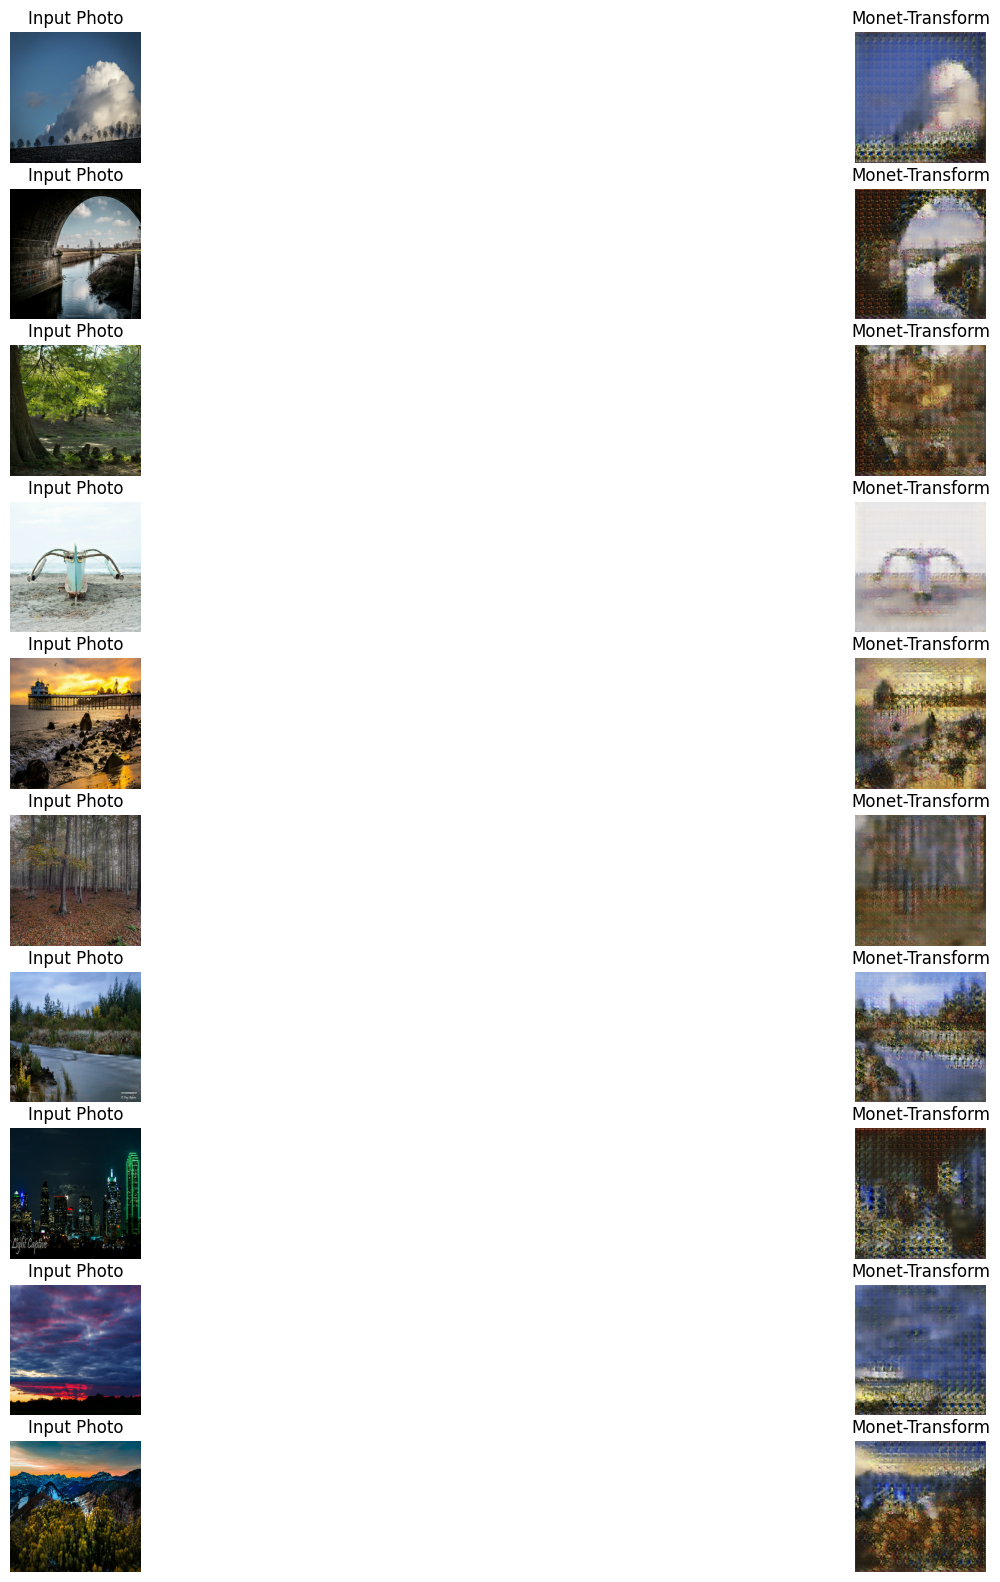

In [19]:
_, ax = plt.subplots(10, 2, figsize=(20, 20))
for i, img in enumerate(photo_ds.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-Transform")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Image Comparison

#Show Before and after images of photos

sdg used learning rate .01, momentum .05, NaN

sdg used learning rate .025, momentum .025, NaN

sdg used learning rate .01, momentum .01, NaN

sdg used learning rate .001, momentum .001, NaN


**Disuss Images**


### Conclusion

**Image Comparison**



**Dicussion**
Varying batch sizes from (4,4) to 8 and 2 slowed perfromance


**Submission**



### References

GAN — CycleGAN (Playing magic with pictures), https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7

Monet CycleGAN Tutorial, https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

Train your first CycleGAN for Image to Image Translation, https://blog.jaysinha.me/train-your-first-cyclegan-for-image-to-image-translation/

Overview of CycleGAN architecture and training, https://towardsdatascience.com/overview-of-cyclegan-architecture-and-training-afee31612a2f#:~:text=A%20CycleGAN%20is%20composed%20of,other%20transform%20zebras%20into%20horses.

Tensorflow CycleGan, https://www.tensorflow.org/tutorials/generative/cyclegan

A hands-on guide to TFRecords, https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c

### Kaggle Code Refernces
CycleGAN Monet, https://www.kaggle.com/code/anubhav012/cyclegan-monet

Monet Who?, https://www.kaggle.com/code/nisargbhatt/monet-who